# Plot all Poisson weights and smoothings together 


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: marcodia
"""
import numpy as np
import random
import xarray as xr
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import math

from sklearn import preprocessing
import tensorflow as tf

import import_ipynb
import sys
import os 

import network_arch as network
import metrics
import plot as plot
import settings
import functions_misc as fnc


from cartopy import config
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing

import pop_tools


2024-01-26 16:45:40.220429: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


importing Jupyter notebook from network_arch.ipynb
importing Jupyter notebook from metrics.ipynb
importing Jupyter notebook from plot.ipynb
importing Jupyter notebook from settings.ipynb
importing Jupyter notebook from functions_misc.ipynb


In [2]:
EXPERIMENT = 'exp_4/exp_400'


ddir_X = '/Users/marcodia/Research/Data/global_daily_anomalies/'
ddir_Y = '/Users/marcodia/Research/Data/processed_fields/precip_data/'
#ddir_out = '/Users/marcodia/Research/salinity_s2s/experiments/Updated_NNs/tuner/4_wk/' 


params = settings.get_settings(EXPERIMENT)

PREDICTOR_VAR  = params['PREDICTOR_VAR']           
PREDICTAND_VAR = params['PREDICTAND_VAR']              
REGION_TOR     = params['REGION_TOR']          
REGION_TAND    = params['REGION_TAND']            
training_ens   = params['training_ens']            
validation_ens = params['validation_ens']           
testing_ens    = params['testing_ens']           
train_list     = params['train_list']
val_list       = params['val_list']
lead           = params['lead']            
days_average   = params['days_average']            
GLOBAL_SEED    = params['GLOBAL_SEED']            
HIDDENS        = params['HIDDENS']          
DROPOUT        = params['DROPOUT']            
RIDGE1         = params['RIDGE1']                    
LR_INIT        = params['LR_INIT']
BATCH_SIZE     = params['BATCH_SIZE']           
RANDOM_SEED    = params['RANDOM_SEED']            
act_fun        = params['act_fun']            
N_EPOCHS       = params['N_EPOCHS']           
PATIENCE       = params['PATIENCE']   
CLASS_WEIGHT   = 'none'

window_size = days_average
days_average

3

In [3]:
lead_weeks = int(lead/7)
lead_weeks

4

In [4]:
rolling_input_window_X = 3
rolling_input_window_Y = 1

In [5]:
def is_mam(month):
    return np.logical_and(month>=3, month<=5)

def is_may(month):
    return np.logical_and(month>=5, month<=5)

def is_aug(month):
    return np.logical_and(month>=8, month<=8)

#>>>>>SET UP <<<<<<<<<<<<<<<
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.compat.v1.random.set_random_seed(GLOBAL_SEED)

NLABEL = 2

YEARS = '1850-1949'
STRT_I = pd.to_datetime('01-01-1850')
END_I   = pd.to_datetime('12-31-1949')  + dt.timedelta(days=1)

time_range = xr.cftime_range(str(STRT_I)[:10], str(END_I)[:10],calendar = 'noleap') #[0:10] corresponds to full datestamp
#time_range_szn = time_range.where(fnc.is_mjja(time_range.month)).dropna()
TIME_ALL = xr.DataArray(time_range + dt.timedelta(days=0), dims=['time'])     

STRT_2 = pd.to_datetime('05-01-1850')
END_2   = pd.to_datetime('08-31-1949')  + dt.timedelta(days=1)
time_range2 = xr.cftime_range(str(STRT_2)[:10], str(END_2)[:10],calendar = 'noleap') #[0:10] corresponds to full datestamp
time_range_2 = time_range2.where(fnc.is_mjja(time_range2.month)).dropna()
TIME_X = xr.DataArray(time_range_2 + dt.timedelta(days=0), dims=['time'])   

TIME_Y = xr.DataArray(time_range_2 + dt.timedelta(days=lead+days_average), dims=['time'])  #below comment explains time segmentation


In [6]:
# ----- X TRAINING ------
min_lon = 260 
min_lat = -20 
max_lon = 360 
max_lat = 70 


count = 0 
for i in train_list:
    X_finame = PREDICTOR_VAR+'_'+REGION_TOR+'_'+YEARS+'_'+'ens'+i+'_dailyanom_detrend.nc'
    X_all_full = xr.open_dataarray(ddir_X+X_finame)
    X1 = X_all_full.where(X_all_full.time == TIME_ALL, drop=True)
    X = X1.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
    
    X_nptime = np.array(X.time)                 #for some annoying reason, it needed to be converted to numpy for creating DataArray   
    X_nplat = np.array(X.lat)
    X_nplon = np.array(X.lon)
    del X_all_full 

    if count == 0: # don't rewrite empty matrix each time 
        X_all1_FULL = xr.DataArray(np.zeros((len(train_list),X.shape[0],X.shape[1],X.shape[2]))+np.nan,
                             dims = ['ens','time','lat','lon'],
                             coords = [('ens',np.arange(0,len(train_list))),('time', X_nptime),('lat',X_nplat),('lon',X_nplon)])

    X_all1_FULL[count,:,:,:] = X   
    
    count = count+1
    del X

X_all1_ROLL = X_all1_FULL.rolling(time=(rolling_input_window_X),center=False).mean()
X_all1_inputtime1 = X_all1_ROLL.where(X_all1_ROLL.time == TIME_X, drop=True)
X_all1_inputtime = X_all1_inputtime1.dropna(dim='time', how = 'all')

Xtrain1 = X_all1_inputtime.stack(time_all=('ens','time')) # lat,lon,time*8 (8= number of training ens members) 
Xtrain1 = Xtrain1.transpose('time_all','lat','lon') # time*8,lat,lon
Xtrain_std1 = np.std(Xtrain1,axis=0)
Xtrain_mean1 = np.mean(Xtrain1,axis=0)
Xtrain_full = (Xtrain1-Xtrain_mean1)/Xtrain_std1


del X_all1_ROLL, X_all1_inputtime1, X1, Xtrain1

/Users/marcodia/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## Apply Mask

In [7]:
# Define latitude and longitude ranges that correspond to the Pacific Ocean
pacific_lat_range = slice(0, 14)  # Adjust the latitudes as needed
pacific_lon_range = slice(0, 11)  # Adjust the longitudes as needed

# Create a mask for the Pacific Ocean
mask = np.zeros(Xtrain_full.shape[1:], dtype=bool)
mask[pacific_lat_range, pacific_lon_range] = True

# Expand the mask to match the 'time' dimension
mask_expanded = np.repeat(mask[None, :, :], len(Xtrain_full.time_all), axis=0)

# Apply the mask to the dataset
Xtrain = Xtrain_full.where(~mask_expanded, np.nan)

In [8]:
# ---------- X VALIDATION----------
count = 0 
for i in val_list:
    X_finame = PREDICTOR_VAR+'_'+REGION_TOR+'_'+YEARS+'_'+'ens'+i+'_dailyanom_detrend.nc'
    X_all_full = xr.open_dataarray(ddir_X+X_finame)
    X1 = X_all_full.where(X_all_full.time == TIME_ALL, drop=True)
    X = X1.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
    
    X_nptime = np.array(X.time)                 #for some annoying reason, it needed to be converted to numpy for creating DataArray   
    X_nplat = np.array(X.lat)
    X_nplon = np.array(X.lon)
    del X_all_full 

    if count == 0: # don't rewrite empty matrix each time 
        X_val1_FULL = xr.DataArray(np.zeros((len(val_list),X.shape[0],X.shape[1],X.shape[2]))+np.nan,
                             dims = ['ens','time','lat','lon'],
                             coords = [('ens',np.arange(0,len(val_list))),('time', X_nptime),('lat',X_nplat),('lon',X_nplon)])

    X_val1_FULL[count,:,:,:] = X   
    
    count = count+1
    del X

X_val1_ROLL = X_val1_FULL.rolling(time=(rolling_input_window_X),center=False).mean()
X_val1_inputtime1 = X_val1_ROLL.where(X_val1_ROLL.time == TIME_X, drop=True)
X_val1_inputtime = X_val1_inputtime1.dropna(dim='time', how = 'all')
Xval1 = X_val1_inputtime.stack(time_all=('ens','time')) # lat,lon,time*8 (8= number of training ens members) 
Xval1 = Xval1.transpose('time_all','lat','lon') # time*8,lat,lon

Xval_full = (Xval1 - Xtrain_mean1)/Xtrain_std1

# Create a mask for the Pacific Ocean
mask = np.zeros(Xval_full.shape[1:], dtype=bool)
mask[pacific_lat_range, pacific_lon_range] = True

# Expand the mask to match the 'time' dimension
mask_expanded = np.repeat(mask[None, :, :], len(Xval_full.time_all), axis=0)

# Apply the mask to the dataset
Xval = Xval_full.where(~mask_expanded, np.nan)

In [9]:
# ---------- X TESTING----------
X_finame1  = PREDICTOR_VAR+'_'+REGION_TOR+'_'+YEARS+'_'+'ens'+str(testing_ens)+'_dailyanom_detrend.nc'
Xtest1_full = xr.open_dataarray(ddir_X+X_finame1)
Xtest_1= Xtest1_full.where(Xtest1_full.time == TIME_ALL, drop=True)
Xtest1 = Xtest_1.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

X_test1_ROLL = Xtest1.rolling(time=(rolling_input_window_X),center=False).mean()
X_test1_inputtime1 = X_test1_ROLL.where(X_test1_ROLL.time == TIME_X, drop=True)
X_test1_inputtime = X_test1_inputtime1.dropna(dim='time', how = 'all')

Xtest_full = (X_test1_inputtime - Xtrain_mean1)/Xtrain_std1

# Create a mask for the Pacific Ocean
mask = np.zeros(Xtest_full.shape[1:], dtype=bool)
mask[pacific_lat_range, pacific_lon_range] = True

# Expand the mask to match the 'time' dimension
mask_expanded = np.repeat(mask[None, :, :], len(Xtest_full.time), axis=0)

# Apply the mask to the dataset
Xtest = Xtest_full.where(~mask_expanded, np.nan)

In [10]:
del Xtrain_std1, X_test1_inputtime, X_test1_inputtime1, X_test1_ROLL, Xtest1, Xtest_1, Xtest1_full, Xtrain_mean1, X_val1_inputtime, X_val1_ROLL

## Apply Poisson Weighting

In [11]:
lambda_value = [0,7,14,21,28,35,42,49,56,63,70,77,84]
fill_val = np.arange(0,120)

poisson_weights = np.zeros((len(lambda_value),len(fill_val)))
k_lead = 119 

# Calculate Poisson weights for lambda=14 and max value=30
count = 0
for l in lambda_value:
    poisson_weights[count,:] = fnc.calculate_poisson_weights(l, k_lead)
    count += 1

poisson_weights_T = np.transpose(poisson_weights)

poisson_use = poisson_weights_T[:,lead_weeks]   #THIS NEEDS TO BE SPECIFIED BASED ON LEAD TIME

# Example usage:
weight_vector = poisson_use  # Symmetric weights for a centered rolling average

center_element = lead

In [12]:
#%% ----- Y TRAINING--------

count = 0
for i in train_list:
    Ytrain_finame = PREDICTAND_VAR+'_'+REGION_TAND+'_'+YEARS+'_ens'+str(i)+'_'+str(window_size)+'daysum.nc'

    Y_all_full = xr.open_dataarray(ddir_Y+Ytrain_finame)
    Y = Y_all_full.where(Y_all_full.time == TIME_ALL, drop=True)

    Y_nptime = np.array(Y.time)                 
    del Y_all_full 

    if count == 0: # don't rewrite empty matrix each time 
        Y_all = xr.DataArray(np.zeros((len(train_list),Y.shape[0]))+np.nan,
                             dims = ['ens','time'],
                             coords = [('ens',np.arange(0,len(train_list))),('time', Y_nptime)])
        
        poiss_weighted_rolling_avg = xr.DataArray(np.zeros((len(train_list),Y.shape[0]))+np.nan,
                              dims = ['ens','time'],
                            coords = [('ens',np.arange(0,len(train_list))),('time', Y_nptime)])

    Y_all[count,:] = Y   

    centered_weighted_rolling_avg = fnc.uncentered_weighted_rolling_average(Y_all[count,:], weight_vector,center_element)
    poiss_weighted_rolling_avg[count,:] = centered_weighted_rolling_avg   

    count = count + 1

Y_all1_inputtime1 = poiss_weighted_rolling_avg.where(poiss_weighted_rolling_avg.time == TIME_Y, drop=True)
Y_all1_inputtime = Y_all1_inputtime1.dropna(dim='time', how = 'all')
np.arange(Y_all1_inputtime.shape[0])

YP_nptime = np.array(Y_all1_inputtime.time)
Y_all_perc = xr.DataArray(np.zeros((len(train_list),Y_all1_inputtime.shape[1]))+np.nan,
                             dims = ['ens','time'],
                             coords = [('ens',np.arange(0,len(train_list))),('time', YP_nptime)])

for i in np.arange(Y_all1_inputtime.shape[0]):
    heavy_val = np.percentile(Y_all1_inputtime[i,:], 80)
    Y_all_perc[i,:] = (Y_all1_inputtime[i,:] >= heavy_val).astype(int) #+ (Y_use >= mod_val).astype(int)

Ytrain = Y_all_perc.stack(time_all=('ens','time'))
# How often does our data fall into each category? This is just for the last ensemble member in training
calcpercent = lambda cat: str((np.sum(np.array(Ytrain) == cat)/len(Ytrain)*100).astype(int))

# Print out the sizes of each class
print('Frequency for each Precip Category')
print('Light: ' + calcpercent(0) + '%')
print('Heavy: ' + calcpercent(1) + '%')

Frequency for each Precip Category
Light: 80%
Heavy: 20%


In [13]:
#%% ----- Y VALIDATION--------

count = 0
for i in val_list:
    Yval_finame = PREDICTAND_VAR+'_'+REGION_TAND+'_'+YEARS+'_ens'+str(i)+'_'+str(window_size)+'daysum.nc'

    Y_all_full = xr.open_dataarray(ddir_Y+Yval_finame)
    Y = Y_all_full.where(Y_all_full.time == TIME_ALL, drop=True)

    Y_nptime = np.array(Y.time)                 
    del Y_all_full 
    
 #   $$$$$$$
    if count == 0: # don't rewrite empty matrix each time 
        Y_all = xr.DataArray(np.zeros((len(val_list),Y.shape[0]))+np.nan,
                             dims = ['ens','time'],
                             coords = [('ens',np.arange(0,len(val_list))),('time', Y_nptime)])
        
        val_poiss_weighted_rolling_avg = xr.DataArray(np.zeros((len(val_list),Y.shape[0]))+np.nan,
                              dims = ['ens','time'],
                            coords = [('ens',np.arange(0,len(val_list))),('time', Y_nptime)])

    Y_all[count,:] = Y   

    val_centered_weighted_rolling_avg = fnc.uncentered_weighted_rolling_average(Y_all[count,:], weight_vector, center_element)
    val_poiss_weighted_rolling_avg[count,:] = val_centered_weighted_rolling_avg   

    count = count + 1

Y_val1_inputtime1 = val_poiss_weighted_rolling_avg.where(val_poiss_weighted_rolling_avg.time == TIME_Y, drop=True)
Y_val1_inputtime = Y_val1_inputtime1.dropna(dim='time', how = 'all')

YP_nptime = np.array(Y_all1_inputtime.time)
Y_val_perc = xr.DataArray(np.zeros((len(val_list),Y_all1_inputtime.shape[1]))+np.nan,
                             dims = ['ens','time'],
                             coords = [('ens',np.arange(0,len(val_list))),('time', YP_nptime)])

for i in np.arange(Y_val1_inputtime.shape[0]):
    heavy_val = np.percentile(Y_val1_inputtime[i,:], 80)
    Y_val_perc[i,:] = (Y_val1_inputtime[i,:] >= heavy_val).astype(int) #+ (Y_use >= mod_val).astype(int)

Yval = Y_val_perc.stack(time_all=('ens','time'))
# How often does our data fall into each category? This is just for the last ensemble member in validation
calcpercent = lambda cat: str((np.sum(np.array(Yval) == cat)/len(Yval)*100).astype(int))

# Print out the sizes of each class
print('Frequency for each Precip Category')
print('Light: ' + calcpercent(0) + '%')
print('Heavy: ' + calcpercent(1) + '%')
    

Frequency for each Precip Category
Light: 80%
Heavy: 20%


In [14]:
# ----- Y TESTING --------
Ytest_finame = PREDICTAND_VAR+'_'+REGION_TAND+'_'+YEARS+'_ens'+str(testing_ens)+'_'+str(window_size)+'daysum.nc'

Y_test_full = xr.open_dataarray(ddir_Y+Ytest_finame)
Y = Y_test_full.where(Y_test_full.time == TIME_ALL, drop=True)
Y_nptime = np.array(Y.time)

c_temp = xr.DataArray(np.zeros(Y.shape[0])+np.nan,
                              dims = ['time'],
                            coords = [('time', Y_nptime)])

c_temp[:] = fnc.uncentered_weighted_rolling_average(Y,weight_vector,center_element)

Y_test1_inputtime1 = c_temp.where(c_temp.time == TIME_Y, drop=True)
Y_test1_inputtime = Y_test1_inputtime1.dropna(dim='time', how = 'all')
   
heavy_val = np.percentile(Y_test1_inputtime, 80)
Ytest = (Y_test1_inputtime >= heavy_val).astype(int) 

calcpercent = lambda cat: str((np.sum(np.array(Ytest) == cat)/len(Ytest)*100).astype(int))

# Print out the sizes of each class
print('Frequency for each Precip Category')
print('Light: ' + calcpercent(0) + '%')
print('Heavy: ' + calcpercent(1) + '%')

Frequency for each Precip Category
Light: 80%
Heavy: 20%


In [15]:
c_temp.shape

(36497,)

In [16]:
lambda_value = [0,7,14,21,28,35,42,49,56,63,70,77,84]
fill_val = np.arange(0,120)

poisson_weights = np.zeros((len(lambda_value),len(fill_val)))
k_lead = 119 

# Calculate Poisson weights for lambda=14 and max value=30
count = 0
for l in lambda_value:
    poisson_weights[count,:] = fnc.calculate_poisson_weights(l, k_lead)
    count += 1

poisson_weights_T = np.transpose(poisson_weights)

poiss_timeseries = xr.DataArray(np.zeros((len(lambda_value)-4,Y.shape[0]))+np.nan,
                              dims = ['lead_week','time'],
                            coords = [('lead_week',np.arange(0,len(lambda_value)-4)),('time', Y_nptime)])
poiss_timeseries.shape

(9, 36497)

In [17]:
for l in np.arange(0,len(lambda_value)-4):
    poisson_use_all = poisson_weights_T[:,l]   #THIS NEEDS TO BE SPECIFIED BASED ON LEAD TIME
    weight_vector = poisson_use_all  # Symmetric weights for a centered rolling average
    center_element = l*7
    poiss_timeseries[l,:] = fnc.uncentered_weighted_rolling_average(Y,weight_vector,center_element)

In [18]:
poiss_timeseries

<xarray.DataArray (lead_week: 9, time: 36497)>
array([[2.86443824, 4.17419648, 3.8500475 , ..., 0.3360942 , 0.31513643,
        0.04105841],
       [1.58492025, 1.90733691, 2.09067401, ..., 3.28088872, 2.09940326,
        1.1262804 ],
       [1.38293677, 1.58567828, 1.7432198 , ..., 3.06784646, 2.44865   ,
        1.80401833],
       ...,
       [1.36422346, 1.55102036, 1.75181698, ..., 2.30266289, 2.10572982,
        1.88381152],
       [1.4126979 , 1.60268953, 1.80729866, ..., 2.204555  , 2.03454099,
        1.8433754 ],
       [1.46235734, 1.65347668, 1.85866117, ..., 2.12299245, 1.97281737,
        1.80451233]])
Coordinates:
  * lead_week  (lead_week) int64 0 1 2 3 4 5 6 7 8
  * time       (time) object 1850-01-04 00:00:00 ... 1949-12-31 00:00:00

In [19]:
timeplot = np.array(poiss_timeseries.time)
timeplot

array([cftime.DatetimeNoLeap(1850, 1, 4, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 5, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 6, 0, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(1949, 12, 29, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1949, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1949, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)

In [20]:
Y.time[3650+361]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1860, 12, 31, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 1860-12-31 00:00:00

In [21]:
strt_ind = 3650
end_ind = strt_ind + 120

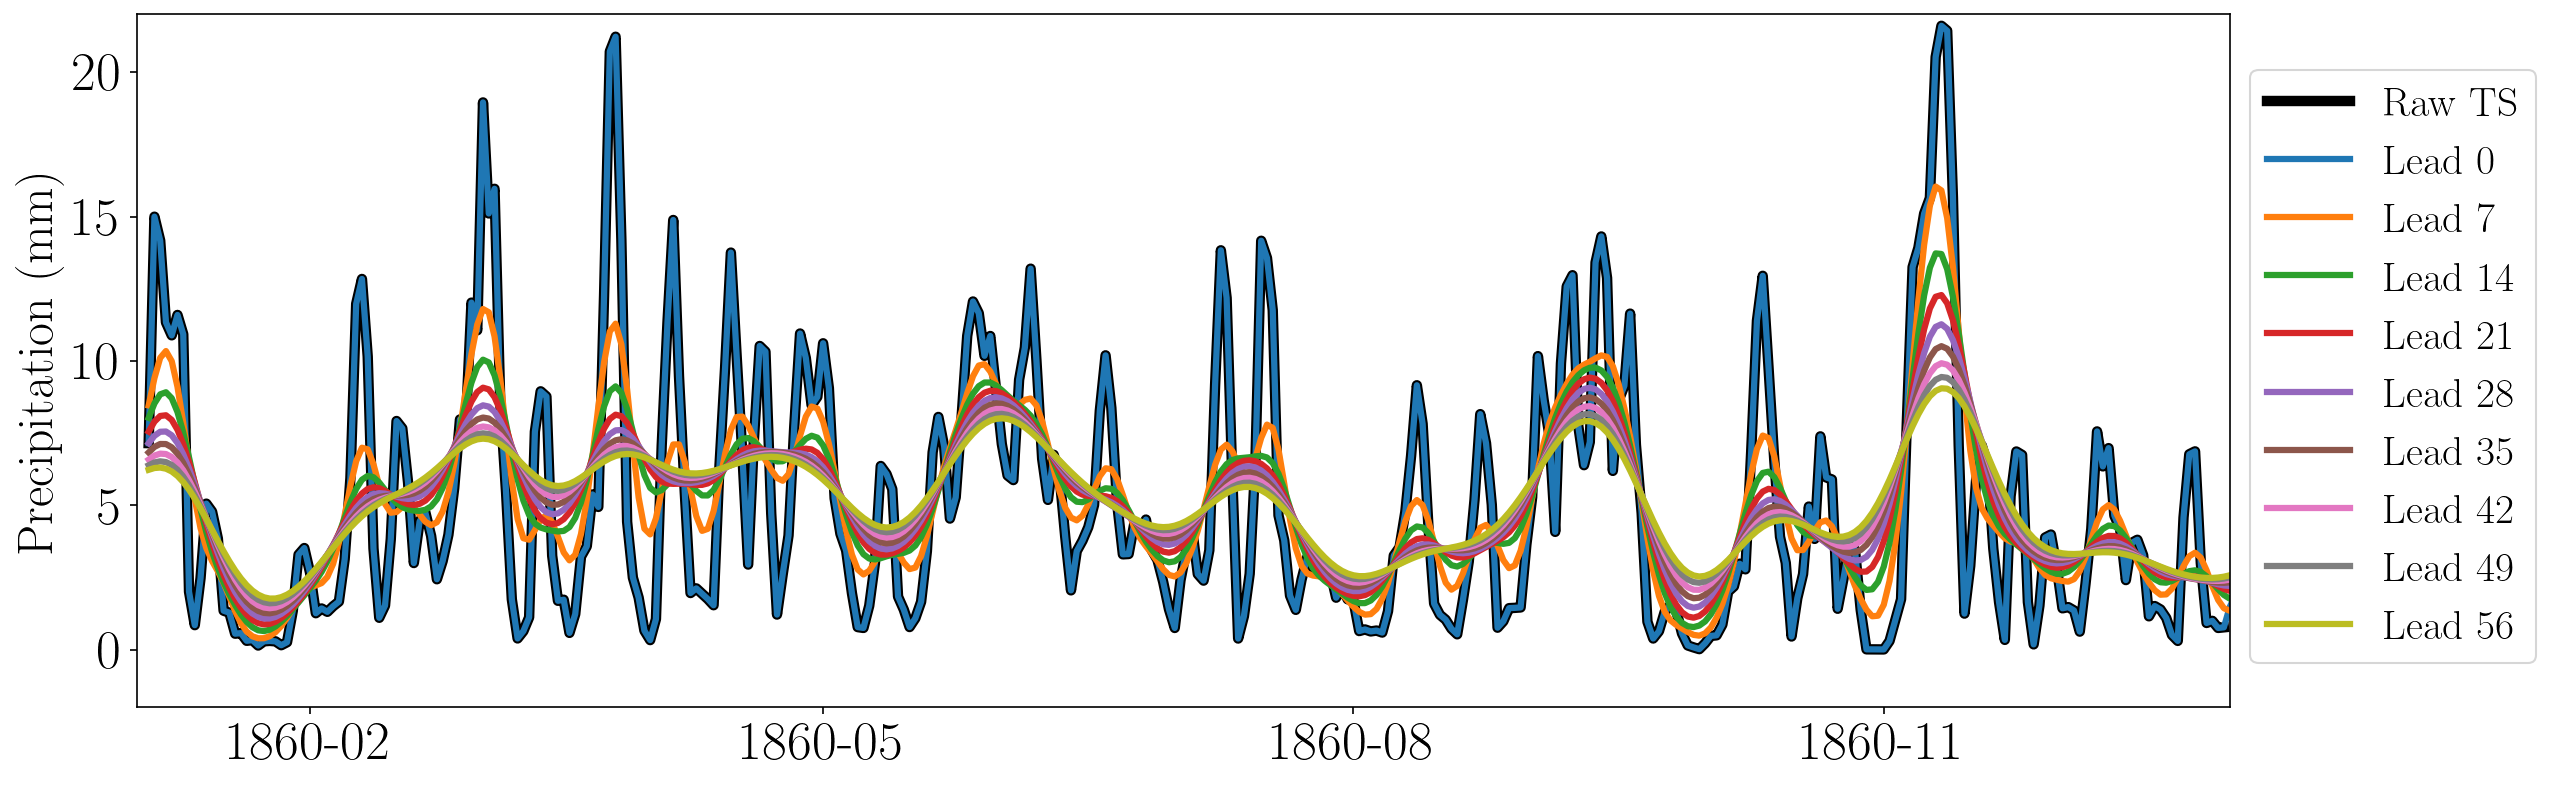

In [38]:
fig, ax = plt.subplots(1,1, figsize=(18,6))
plt.rcParams['font.family'] = "Arial"

plt.plot(Y.time[3650:(3650+361)],Y[3650:(3650+361)],linewidth=5,color='black')
#plt.plot(Y.time[strt_ind:(strt_ind+120)],Y[strt_ind:(strt_ind+120)],linewidth=5,color='black')

for l in np.arange(0,len(lambda_value)-4):
    ax.plot(poiss_timeseries.time[strt_ind:(strt_ind+365)], poiss_timeseries[l,strt_ind:(strt_ind+365)],linewidth=3)
    
    ax.set(xlim=(timeplot[strt_ind-2],timeplot[strt_ind-4+365]))
    #ax.set(xticks=np.arange(timeplot[3648],timeplot[3646+365],step=10))
    ax.set(ylim=(-2,22))
    ax.set(yticks=(np.arange(0,25, step=5)))
    ax.set_ylabel('Precipitation (mm)',fontsize = 24)
    # ax.axhline(y=50, color='black', linestyle='--', linewidth=0.75)

labels = ['Raw TS','Lead 0','Lead 7','Lead 14','Lead 21','Lead 28','Lead 35','Lead 42','Lead 49','Lead 56']
plt.legend(labels, loc='upper left',ncol=1, fontsize=20, bbox_to_anchor=(1, 0.95))
plt.yticks(fontsize=26)
plt.xticks(fontsize=26)

ddir_out = '/Users/marcodia/Research/salinity_s2s/experiments/no_arctic/evaluations/'
plt.savefig(ddir_out+'poisson_timeseries.png', format='png',dpi=150)

In [44]:

strt_ind
len(lambda_value)-4

9

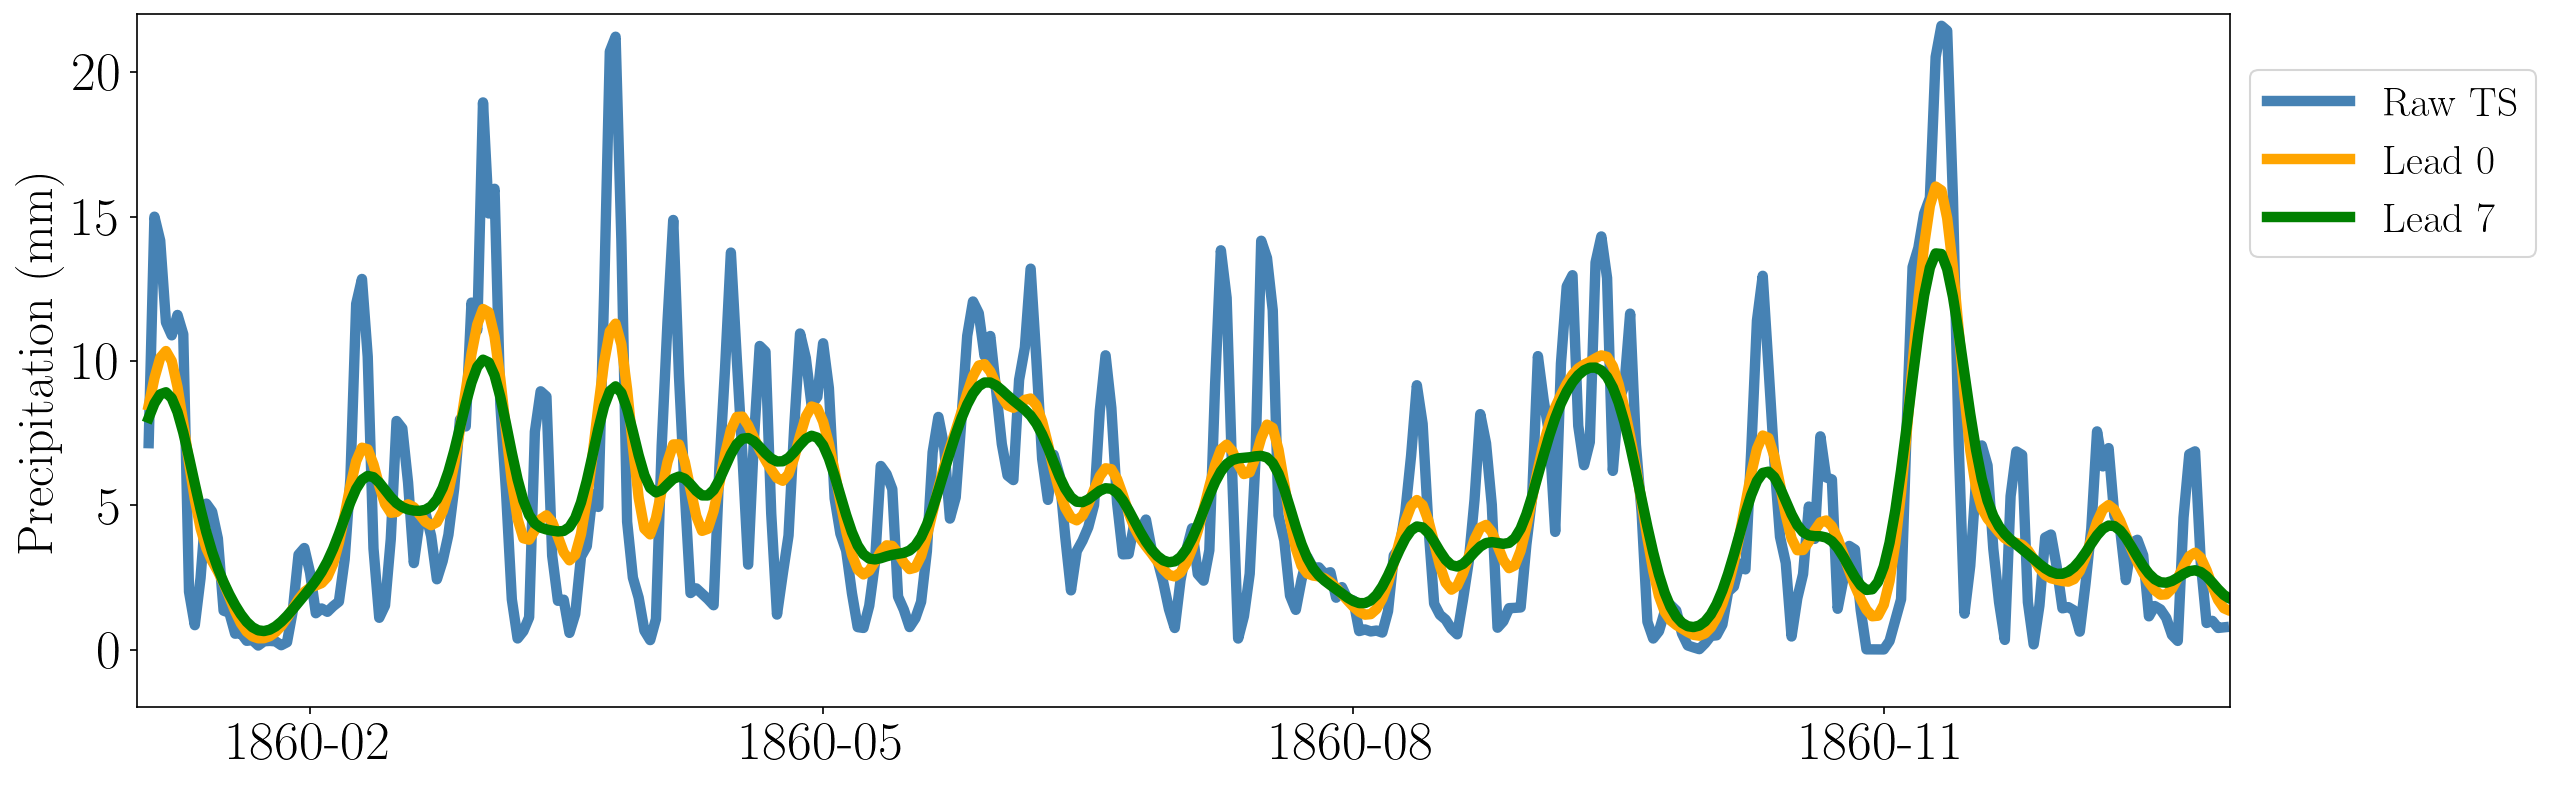

In [66]:
fig, ax = plt.subplots(1,1, figsize=(18,6))
plt.rcParams['font.family'] = "Arial"

plt.plot(Y.time[3650:(3650+361)],Y[3650:(3650+361)],linewidth=5,color='steelblue')
#plt.plot(Y.time[strt_ind:(strt_ind+120)],Y[strt_ind:(strt_ind+120)],linewidth=5,color='black')

#for l in np.arange(0,len(lambda_value)-4):
for l in np.arange(1,3):
    if l == 1:
        ax.plot(poiss_timeseries.time[strt_ind:(strt_ind+365)], poiss_timeseries[l,strt_ind:(strt_ind+365)],linewidth=5, color='orange')
    if l == 2:
        ax.plot(poiss_timeseries.time[strt_ind:(strt_ind+365)], poiss_timeseries[l,strt_ind:(strt_ind+365)],linewidth=5, color='green')
    ax.set(xlim=(timeplot[strt_ind-2],timeplot[strt_ind-4+365]))
    #ax.set(xticks=np.arange(timeplot[3648],timeplot[3646+365],step=10))
    ax.set(ylim=(-2,22))
    ax.set(yticks=(np.arange(0,25, step=5)))
    ax.set_ylabel('Precipitation (mm)',fontsize = 24)
    # ax.axhline(y=50, color='black', linestyle='--', linewidth=0.75)

labels = ['Raw TS','Lead 0','Lead 7','Lead 14','Lead 21','Lead 28','Lead 35','Lead 42','Lead 49','Lead 56']
plt.legend(labels, loc='upper left',ncol=1, fontsize=20, bbox_to_anchor=(1, 0.95))
plt.yticks(fontsize=26)
plt.xticks(fontsize=26)

ddir_out = '/Users/marcodia/Research/salinity_s2s/experiments/no_arctic/evaluations/'
plt.savefig(ddir_out+'poisson_timeseries_week2.png', format='png',dpi=150)

In [24]:
roll_avg = fnc.rolling_average(Y,20, dim='time')

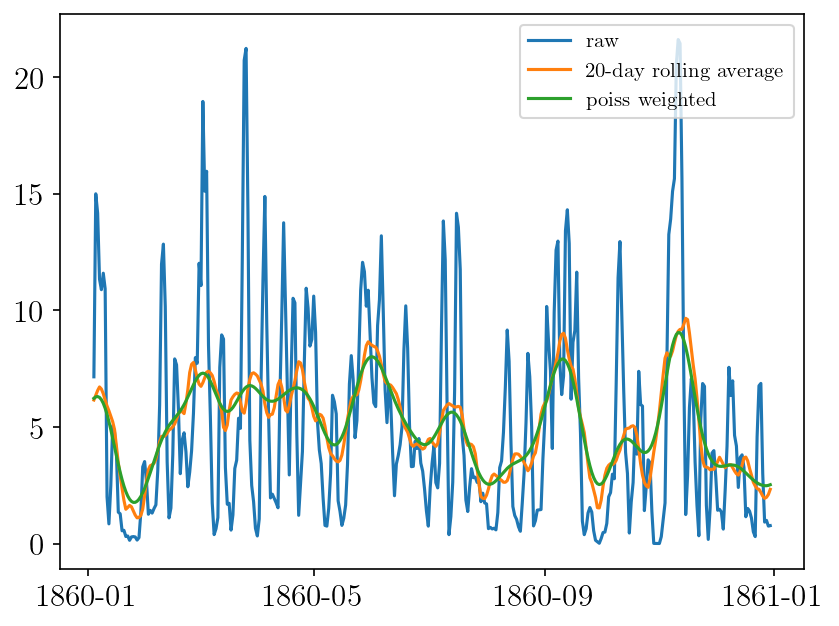

In [25]:
plt.plot(Y.time[3650:(3650+361)],Y[3650:(3650+361)],label='raw')
plt.plot(roll_avg.time[3650:(3650+361)],roll_avg[3650:(3650+361)],label='20-day rolling average')
plt.plot(poiss_timeseries.time[3650:(3650+361)],poiss_timeseries[8,3650:(3650+361)],label='poiss weighted')
plt.legend(loc='upper right',fontsize=10)

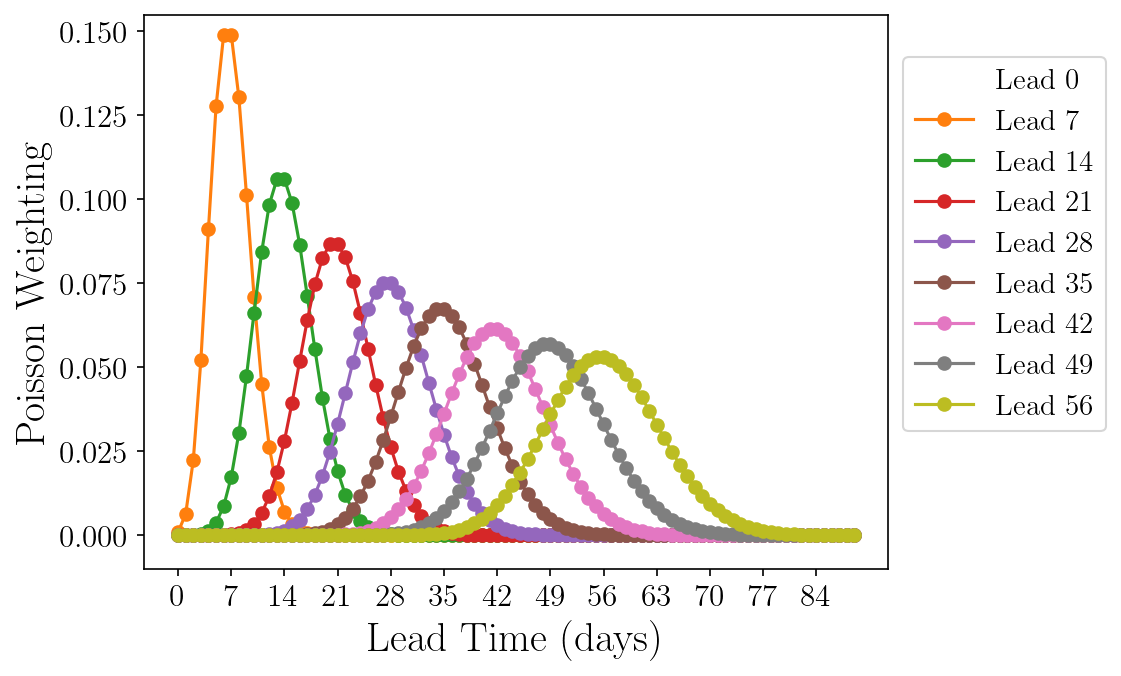

In [39]:
plt.rcParams['font.family'] = "Arial"
#plt.plot(fill_val,np.zeros(poisson_weights_T.shape),label='',color='white')
plt.plot(fill_val[:90], poisson_weights_T[:90,0], marker='o',alpha=0.0)
plt.plot(fill_val[:90], poisson_weights_T[:90,1:9], marker='o')
labels = ['Lead 0','Lead 7','Lead 14','Lead 21','Lead 28','Lead 35','Lead 42','Lead 49','Lead 56']
plt.legend(labels, loc='upper left',ncol=1, fontsize=14, bbox_to_anchor=(1, 0.95))
plt.ylim(-0.01,0.155)
plt.xticks(np.arange(0,91,7))
plt.xlabel('Lead Time (days)',fontsize=20)
plt.ylabel('Poisson Weighting',fontsize=20)

plt.savefig(ddir_out+'poisson_weights.png', format='png',dpi=150)

In [63]:
ddir_out

'/Users/marcodia/Research/salinity_s2s/experiments/no_arctic/evaluations/'

In [27]:
#Balance Classes
#Training
# make Yval have equal 0s and 1s so that random chance is 50%
n_valzero = np.shape(np.where(Ytrain==0)[0])[0]
n_valone  = np.shape(np.where(Ytrain==1)[0])[0]
i_valzero = np.where(Ytrain==0)[0]
i_valone  = np.where(Ytrain==1)[0]

if n_valone > n_valzero:
    isubset_valone = np.random.choice(i_valone,size=n_valzero,replace=False)
    i_valnew = np.sort(np.append(i_valzero,isubset_valone))
    Y_train_1D = Ytrain.isel(time_all=i_valnew,drop=True)
    X_train_w_NANS  = Xtrain[i_valnew]#.stack(z=('lat','lon'))
elif n_valone < n_valzero:
    isubset_valzero = np.random.choice(i_valzero,size=n_valone,replace=False)
    i_valnew = np.sort(np.append(isubset_valzero,i_valone))
    Y_train_1D = Ytrain.isel(time_all=i_valnew,drop=True)
    X_train_w_NANS  = Xtrain[i_valnew]#.stack(z=('lat','lon'))
else:
    X_train_w_NANS = Xtrain#.stack(z=('lat','lon'))

#Validation
# make Yval have equal 0s and 1s so that random chance is 50%
n_valzero = np.shape(np.where(Yval==0)[0])[0]
n_valone  = np.shape(np.where(Yval==1)[0])[0]
i_valzero = np.where(Yval==0)[0]
i_valone  = np.where(Yval==1)[0]

if n_valone > n_valzero:
    isubset_valone = np.random.choice(i_valone,size=n_valzero,replace=False)
    i_valnew = np.sort(np.append(i_valzero,isubset_valone))
    Y_val_1D = Yval.isel(time_all=i_valnew,drop=True)
    X_val_w_NANS  = Xval[i_valnew]#.stack(z=('lat','lon'))
elif n_valone < n_valzero:
    isubset_valzero = np.random.choice(i_valzero,size=n_valone,replace=False)
    i_valnew = np.sort(np.append(isubset_valzero,i_valone))
    Y_val_1D = Yval.isel(time_all=i_valnew,drop=True)
    X_val_w_NANS  = Xval[i_valnew]#.stack(z=('lat','lon'))
else:
    X_val_w_NANS = Xval#.stack(z=('lat','lon'))
    
#Testing
# make Ytest have equal 0s and 1s so that random chance is 50%
n_valzero = np.shape(np.where(Ytest==0)[0])[0]
n_valone  = np.shape(np.where(Ytest==1)[0])[0]
i_valzero = np.where(Ytest==0)[0]
i_valone  = np.where(Ytest==1)[0]

if n_valone > n_valzero:
    isubset_valone = np.random.choice(i_valone,size=n_valzero,replace=False)
    i_valnew = np.sort(np.append(i_valzero,isubset_valone))
    Y_test_1D = Ytest.isel(time=i_valnew,drop=True)
    X_test_w_NANS  = Xtest[i_valnew]#.stack(z=('lat','lon'))
elif n_valone < n_valzero:
    isubset_valzero = np.random.choice(i_valzero,size=n_valone,replace=False)
    i_valnew = np.sort(np.append(isubset_valzero,i_valone))
    Y_test_1D = Ytest.isel(time=i_valnew,drop=True)
    X_test_w_NANS  = Xtest[i_valnew]#.stack(z=('lat','lon'))
else:
    X_test_w_NANS = Xtest#.stack(z=('lat','lon'))

In [28]:
X_train_stack = X_train_w_NANS.stack(z=('lat','lon'))
X_train = X_train_stack.dropna(dim="z", how="any")

X_val_stack = X_val_w_NANS.stack(z=('lat','lon'))
X_val = X_val_stack.dropna(dim="z", how="any")

X_test_stack = X_test_w_NANS.stack(z=('lat','lon'))
X_test = X_test_stack.dropna(dim="z", how="any")

enc = preprocessing.OneHotEncoder()
Y_train      = enc.fit_transform(np.array(Y_train_1D).reshape(-1, 1)).toarray()
Y_val  = enc.fit_transform(np.array(Y_val_1D).reshape(-1, 1)).toarray()
Y_test  = enc.fit_transform(np.array(Y_test_1D).reshape(-1, 1)).toarray()

In [29]:
X_train.shape

(34440, 807)

In [30]:
Y_train_1D.shape

(34440,)

In [31]:
Y_val.shape

(9840, 2)

In [32]:
X_test.shape

(4920, 807)

In [33]:
Y_test.shape

(4920, 2)

In [34]:
del Y_val1_inputtime, Yval, Y_val1_inputtime1, Ytrain

In [35]:
del X_val1_inputtime1, X_all1_inputtime

In [36]:
del val_centered_weighted_rolling_avg, centered_weighted_rolling_avg

# Train NNs

In [27]:
# # MAKE THE NN ARCHITECTURE
def make_model():
    # Define and train the model
    tf.keras.backend.clear_session()
    model = network.defineNN(HIDDENS,
                             input1_shape = X_train.shape[1],
                             output_shape=NLABEL,
                             ridge_penalty1=RIDGE1,
                             dropout=DROPOUT,
                             act_fun='relu',
                             network_seed=NETWORK_SEED)
    
    loss_function = tf.keras.losses.CategoricalCrossentropy()    
    model.compile(
                  optimizer = tf.keras.optimizers.Adam(learning_rate=LR_INIT),
                  loss = loss_function,
                  metrics = [
                      tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None),
                      metrics.PredictionAccuracy(NLABEL)
                      ]
                  )           
    return model, loss_function

## Set up Keras Tuner

In [28]:
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from tensorflow.keras import regularizers
import json

In [30]:
experiment_name = str(lead_weeks)+'week_lead_SSS'
ddir_out = '/Users/marcodia/Research/salinity_s2s/experiments/Updated_NNs/tuner/'+str(lead_weeks)+'_wk/' 
ddir_out

'/Users/marcodia/Research/salinity_s2s/experiments/Updated_NNs/tuner/4_wk/'

In [31]:
#Define Function with Tunable Parameters

class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        #units_tune = hp.Int("units", min_value=32, max_value=512, step=32)   #Use this if I only want 1 layer with tunable number of nodes
        dropout_tune = hp.Choice("dropout",[0.0,.1,.2,.5,.8])                 #Numbers must be float format 
        activation_tune = hp.Choice("activation", ["relu"])                   #To try multiple: hp.Choice("activation", ["relu", "linear"])
        l1_tune = 0.0                                   #lasso regularization
        l2_tune = hp.Choice("ridge", [0.01, 0.1,0.5,1.0,2.0,5.0,10.0])       #Numbers must be float format
        learning_rate_tune = hp.Float("learning_rate", min_value=1e-7, max_value=1e-3, sampling="log")   #Moves along the logarithmic curve  
        
        model = keras.Sequential()
        model.add(layers.Flatten())
        for i in range(hp.Int("num_layers", 1, 2)):
            model.add(
                layers.Dense(
                    units=hp.Int(f"units_{i}", min_value=32, max_value=256, step=32), #tune # of units and tune # of layers 
                    kernel_regularizer = regularizers.l1_l2(l1=l1_tune, l2=l2_tune),
                    activation=activation_tune,
                )
            )
        # Tune whether to use dropout.
        if hp.Boolean("dropout"):
            model.add(layers.Dropout(dropout_tune))
        model.add(layers.Dense(NLABEL, activation="softmax"))   #NLABEL is the number of output classes 

        model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate_tune),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
        
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64, 128, 256, 512]),
            **kwargs,
        )

tuner = kt.RandomSearch(
    MyHyperModel(),
    objective="val_accuracy",     #use validation accuracy to choose which model is the best 
    max_trials=25,                #how many total trials to run during search 
    overwrite=True,
    directory=ddir_out,
    project_name= experiment_name,
)

2023-08-11 22:46:02.298946: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1, 0.2, 0.5, 0.8], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu'], 'ordered': False}
ridge (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0], 'ordered': True}
learning_rate (Float)
{'default': 1e-07, 'conditions': [], 'min_value': 1e-07, 'max_value': 0.001, 'step': None, 'sampling': 'log'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}


In [33]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', #monitor='val_prediction_accuracy'
                                                   patience=25,
                                                   mode='auto',
                                                   restore_best_weights=True,
                                                   verbose=0)

In [34]:
tuner.search(X_train, Y_train, epochs=5000, verbose = 0, validation_data=(X_val, Y_val), callbacks = [es_callback, keras.callbacks.TensorBoard(ddir_out+"TensorBoard_output")])


INFO:tensorflow:Oracle triggered exit


In [43]:
def get_best_model(tuner_results_dir):
    
    best_score = 0 #if score is based on val_loss, then change best_score = np.inf
    hps = dict()
    
    for dirnm in os.listdir(tuner_results_dir):
        print(dirnm)
        if dirnm.startswith("trial"):
            with open(tuner_results_dir + '/' + dirnm + '/trial.json', 'r') as f:
                data = json.load(f)
                print(data)
                score = data['score']
                print(score)
                if score > best_score: #switch sign if score is based on val_loss 
                    best_score = score
                    hps = data['hyperparameters']['values']
                     
    return hps

In [44]:
bestmodel = get_best_model(ddir_out+experiment_name)
bestmodel

trial_09
{'trial_id': '09', 'hyperparameters': {'space': [{'class_name': 'Choice', 'config': {'name': 'dropout', 'default': 0.0, 'conditions': [], 'values': [0.0, 0.1, 0.2, 0.5, 0.8], 'ordered': True}}, {'class_name': 'Choice', 'config': {'name': 'activation', 'default': 'relu', 'conditions': [], 'values': ['relu'], 'ordered': False}}, {'class_name': 'Choice', 'config': {'name': 'ridge', 'default': 0.01, 'conditions': [], 'values': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0], 'ordered': True}}, {'class_name': 'Float', 'config': {'name': 'learning_rate', 'default': 1e-07, 'conditions': [], 'min_value': 1e-07, 'max_value': 0.001, 'step': None, 'sampling': 'log'}}, {'class_name': 'Int', 'config': {'name': 'num_layers', 'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': None}}, {'class_name': 'Int', 'config': {'name': 'units_0', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}}, {'class_name': 'Int', 'confi

{'dropout': 0.5,
 'activation': 'relu',
 'ridge': 0.1,
 'learning_rate': 1.6182195397540547e-05,
 'num_layers': 1,
 'units_0': 128,
 'units_1': 64,
 'batch_size': 32}